# SERPRO - Weather

_Previsão de temperaturas médias com base em dados históricos_

https://www.kaggle.com/c/serpro-weather/

## Referências

### Forecasting Time Series with Multiple Seasonalities using TBATS in Python
- https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a

### Forecasting Time Series With Complex Seasonal Patterns Using Exponential Smoothing
- https://www.tandfonline.com/doi/abs/10.1198/jasa.2011.tm09771

### TBATS Model (Exponential Smoothing State Space Model With Box-Cox Transformation, ARMA Errors, Trend And Seasonal Components)
- https://www.rdocumentation.org/packages/forecast/versions/8.4/topics/tbats

## Importação dos pacotes

In [1]:
# importar pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
#import matplotlib.pyplot as plt
import pickle

In [2]:
# definir parâmetros extras
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

## Definição de parâmetros

In [3]:
# definir frequência a ser considerada no modelo
frequencia = 'D' # 7D 15D 2W 3W M
periodos_ano = 365.25 #24

# definir data inicial de corte
data_inicio_amostra = '2014-11' #'2013-01'

In [4]:
# calcular períodos que cabem em um ano
#intervalo_ano = pd.date_range(start='2018-01-01', end='2019-01-01', freq=frequencia)
#periodos_ano = len(intervalo_ano)
print('Frequência:', frequencia)
print('Períodos em um ano:', periodos_ano)
print('Data de início da amostra:', data_inicio_amostra)

Frequência: D
Períodos em um ano: 365.25
Data de início da amostra: 2014-11


## Carga dos dados

In [5]:
prefixo_arquivos = ''
#prefixo_arquivos = 'https://github.com/hjort/ai-labs/raw/master/kaggle/serpro-weather/'

In [6]:
# carregar arquivo de dados de treino
train_data = pd.read_csv(prefixo_arquivos + 'weather-train.csv', index_col='date', parse_dates=['date'])
train_data.info()
train_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1508 entries, 2012-10-01 to 2016-11-16
Data columns (total 1 columns):
temperature    1507 non-null float64
dtypes: float64(1)
memory usage: 23.6 KB


,temperature
date,
2012-10-01,11.036840
2012-10-02,14.340558
2012-10-03,14.518382
2012-10-04,16.820351
2012-10-05,16.948431


In [7]:
# carregar arquivo de dados de teste
test_data = pd.read_csv(prefixo_arquivos + 'weather-test.csv', index_col='date', parse_dates=['date'])
test_data.info()
test_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 378 entries, 2016-11-17 to 2017-11-29
Empty DataFrame

""
date
2016-11-17
2016-11-18
2016-11-19
2016-11-20
2016-11-21


## Transformações nos dados

In [8]:
# remover valores nulos
data = train_data.dropna()

# reduzir a quantidade de dados para a frequência
##data = data.resample(frequencia).mean()

# filtrar período desejado
data = data[data_inicio_amostra:]
#data = data['2013-01':]
#data = data['2013-01':'2015-12']

# converter temperatura para Kelvin
#data['temperature'] += 273.15

data.head()

,temperature
date,
2014-11-01,8.088661
2014-11-02,5.147852
2014-11-03,8.941599
2014-11-04,14.599624
2014-11-05,12.044759


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 747 entries, 2014-11-01 to 2016-11-16
Data columns (total 1 columns):
temperature    747 non-null float64
dtypes: float64(1)
memory usage: 11.7 KB


In [10]:
data.describe()

,temperature
count,747.000000
mean,14.981741
std,11.726748
min,-20.568680
25%,6.137205
50%,16.053496
75%,24.887476
max,35.738109


## Análise da série temporal

In [11]:
# criar série temporal a partir do dataframe
ts = data['temperature']
##ts = ts.asfreq(frequencia)
ts.head()

date
2014-11-01     8.088661
2014-11-02     5.147852
2014-11-03     8.941599
2014-11-04    14.599624
2014-11-05    12.044759
Name: temperature, dtype: float64

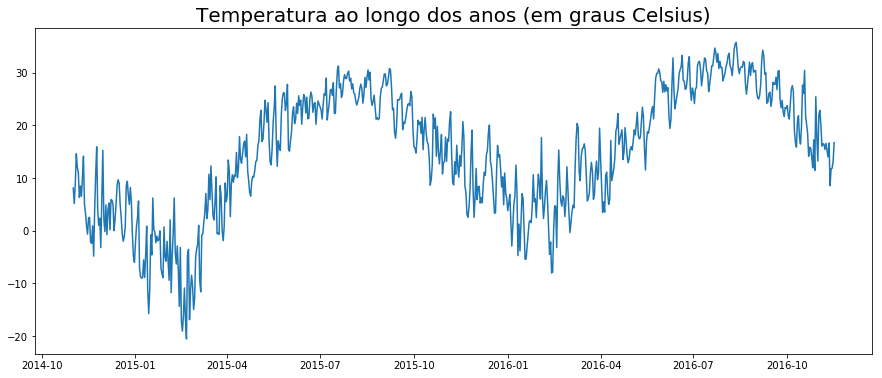

In [12]:
# plotar a série temporal
plt.plot(ts)
plt.title('Temperatura ao longo dos anos (em graus Celsius)', fontsize=20)
plt.show()

## Modelagem preditiva

### Preditor automático TBATS
- https://github.com/intive-DataScience/tbats

In [13]:
from tbats import TBATS, BATS

model = TBATS(seasonal_periods=(2, 365.25), use_trend=True)
%time smodel = model.fit(ts)

print('\n' + smodel.summary())

CPU times: user 4.96 s, sys: 121 ms, total: 5.09 s
Wall time: 40.4 s

Use Box-Cox: False
Use trend: True
Use damped trend: True
Seasonal periods: [  2.   365.25]
Seasonal harmonics [1 2]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.853345
Trend (Beta): -0.195968
Damping Parameter (Phi): 0.800000
Seasonal Parameters (Gamma): [ 1.43154245e-07 -2.29234291e-06  6.03893993e-07  1.54971490e-06]
AR coefficients []
MA coefficients []
Seed vector [ 1.77300262e+01 -7.17946244e-01 -1.80383586e-01 -1.87783328e+12
 -3.23808208e+00  9.32149239e-02 -1.31317764e+01  7.39068594e-01]

AIC 6946.256114


In [14]:
# dividir dados entre treino e teste
corte = int(len(ts) * 0.75)
treino = ts[:corte]
teste = ts[corte:]
print('Treino:', treino.shape)
print('Teste: ', teste.shape)

Treino: (560,)
Teste:  (187,)


### Avaliação do resultado em previsões futuras

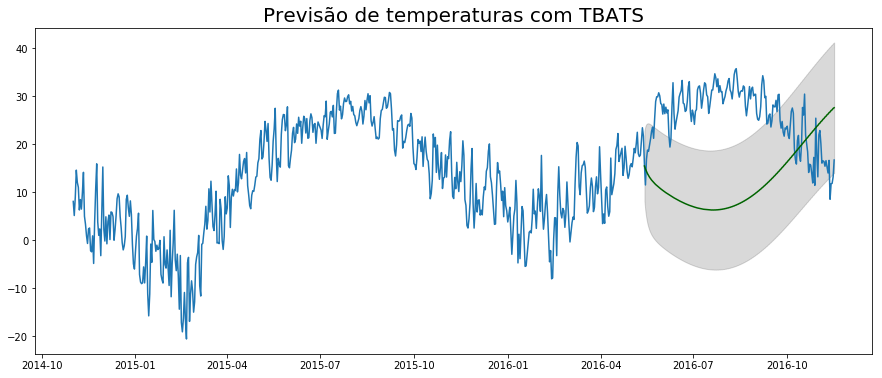

In [15]:
# realizar a previsão
fitted, confidence = smodel.forecast(steps=len(teste), confidence_level=0.95)
index_of_fc = pd.date_range(teste.index[0], periods=len(teste), freq='D')

# criar séries para plotagem
fitted_series = pd.Series(confidence['mean'], index=index_of_fc)
lower_series = pd.Series(confidence['lower_bound'], index=index_of_fc)
upper_series = pd.Series(confidence['upper_bound'], index=index_of_fc)

# plotar gráfico
plt.plot(ts)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index,
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.title("Previsão de temperaturas com TBATS", fontsize=20)
plt.show()

In [16]:
def rmse(predictions, targets):
    assert len(predictions) == len(targets)
    return np.sqrt(np.mean((predictions - targets) ** 2))

def rmsle(predictions, targets):
    assert len(predictions) == len(targets)
    return np.sqrt(np.mean((np.log(1 + predictions) - np.log(1 + targets)) ** 2))

In [17]:
print('RMSE:', rmse(fitted_series, teste))

RMSE: 17.701977165502573


### Previsão de valores futuros com os dados de teste

In [18]:
# obter intervalo de datas para a previsão
primeira_data = test_data.index[0]
ultima_data = test_data.index[-1] #pd.Timestamp(test_data.index[-1], freq='D') + 2
print('Intervalo de datas: %s => %s' % (primeira_data, ultima_data))
datas_previsao = test_data.index #pd.date_range(start=primeira_data, end=ultima_data, freq='D')
datas_previsao

Intervalo de datas: 2016-11-17 00:00:00 => 2017-11-29 00:00:00


DatetimeIndex(['2016-11-17', '2016-11-18', '2016-11-19', '2016-11-20',
               '2016-11-21', '2016-11-22', '2016-11-23', '2016-11-24',
               '2016-11-25', '2016-11-26',
               ...
               '2017-11-20', '2017-11-21', '2017-11-22', '2017-11-23',
               '2017-11-24', '2017-11-25', '2017-11-26', '2017-11-27',
               '2017-11-28', '2017-11-29'],
              dtype='datetime64[ns]', name='date', length=378, freq=None)

In [19]:
# gerar novos valores a partir do modelo
periodos_previsao = len(datas_previsao)
valores_previstos, confianca = smodel.forecast(steps=len(datas_previsao), confidence_level=0.95)

In [20]:
# construir dataframe com previsão
df = pd.DataFrame({
    'date': datas_previsao,
    'temperature': valores_previstos
})
df.set_index('date', inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 378 entries, 2016-11-17 to 2017-11-29
Data columns (total 1 columns):
temperature    378 non-null float64
dtypes: float64(1)
memory usage: 5.9 KB


,temperature
date,
2016-11-17,15.458583
2016-11-18,14.836987
2016-11-19,14.335102
2016-11-20,13.869996
2016-11-21,13.492320


In [21]:
# inserir na primeira posição os últimos valores de treino
#df = (data.iloc[-2:]).append(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 378 entries, 2016-11-17 to 2017-11-29
Data columns (total 1 columns):
temperature    378 non-null float64
dtypes: float64(1)
memory usage: 5.9 KB


In [22]:
# obter intervalo de datas necessário
data_inicio = test_data.index[0]
data_final = test_data.index[-1]
print('Intervalo necessário:', data_inicio, '=>', data_final)

Intervalo necessário: 2016-11-17 00:00:00 => 2017-11-29 00:00:00


In [23]:
# interpolar dados para obter valores diários
##pred_data = df.resample('D').interpolate(method='cubic')

# restringir ao intervalo de datas esperado
pred_data = df
#pred_data = pred_data[data_inicio:data_final]

# converter temperaturas novamente para graus Celsius
#pred_data['temperature'] -= 273.15

# exibir informações do dataframe
pred_data.info()
pred_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 378 entries, 2016-11-17 to 2017-11-29
Data columns (total 1 columns):
temperature    378 non-null float64
dtypes: float64(1)
memory usage: 5.9 KB


,temperature
date,
2016-11-17,15.458583
2016-11-18,14.836987
2016-11-19,14.335102
2016-11-20,13.869996
2016-11-21,13.492320


## Geração do arquivo de resultados

In [24]:
# criar diretório de submissões
!dd="submissions/"; if [ ! -d $dd ]; then mkdir $dd; fi

In [25]:
# gravar arquivo CSV com os resultados
nome_arquivo = 'submissions/weather-submission-tbats-' + \
    data_inicio_amostra + '.csv'
    #frequencia + 'x' + str(periodos_ano) + '-' + 
pred_data.to_csv(nome_arquivo)
print('Arquivo gravado com sucesso:', nome_arquivo)

Arquivo gravado com sucesso: submissions/weather-submission-tbats-2014-11.csv


## Comparação da previsão com dados reais

### Medição do Erro Médio Quadrático (RMSE)